In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, silhouette_score
import pickle
from warnings import filterwarnings
filterwarnings('ignore')
import time

In [2]:
# Read data
pd.set_option('display.max_columns', None)
data = pd.read_csv('C:/Users/HP/.vscode/ML Projects/Telecom Customers Churn/Telecom Customers Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Get information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


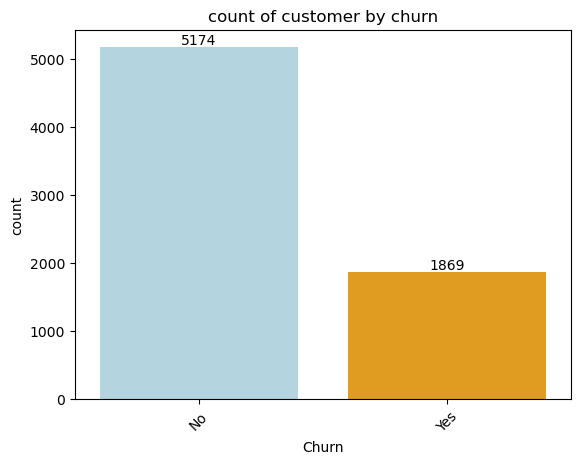

In [6]:
# Visualization of customer by churn
ax = sns.countplot(x='Churn', data=data, palette=['#ADD8E6', '#FFA500'])
ax.bar_label(ax.containers[0])
plt.title("count of customer by churn")
plt.xticks(rotation=45)
plt.show()

***Observation***: The dataset is unbalanced in a near about 3 : 1 ratio for Not-Churn : Churn customers!

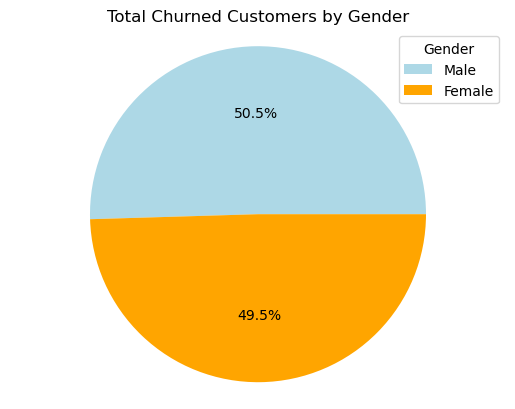

In [29]:
# Visualization for Churned customer gender
gender = data['gender'].value_counts()
plt.pie(gender, labels=None, autopct='%1.1f%%', colors=['#ADD8E6', '#FFA500'])
plt.legend(gender.index, title="Gender", loc="best")
plt.title('Total Churned Customers by Gender')
plt.axis('equal')
plt.show()

***Observation***: The churn rate for male and female customers is quite similar.

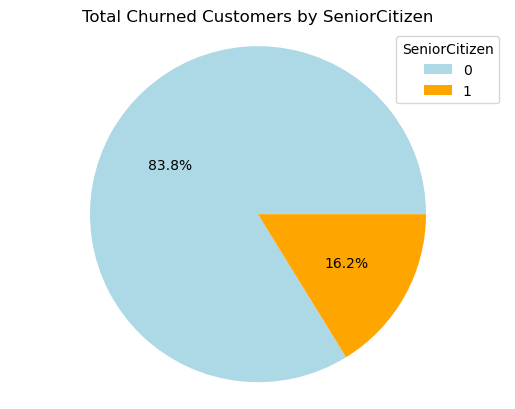

In [30]:
# Visualization of SeniorCitizen
SeniorCitizen = data['SeniorCitizen'].value_counts()
plt.pie(SeniorCitizen, labels=None, autopct='%1.1f%%', colors=['#ADD8E6', '#FFA500'])
plt.legend(SeniorCitizen.index, title="SeniorCitizen", loc="best")
plt.title('Total Churned Customers by SeniorCitizen')
plt.axis('equal')
plt.show()

***Observation***: Only 16% of the customers are senior citizens, indicating that the majority of our customers are younger individuals.

In [5]:
churned_customers = data[data['Churn'] == 'Yes']

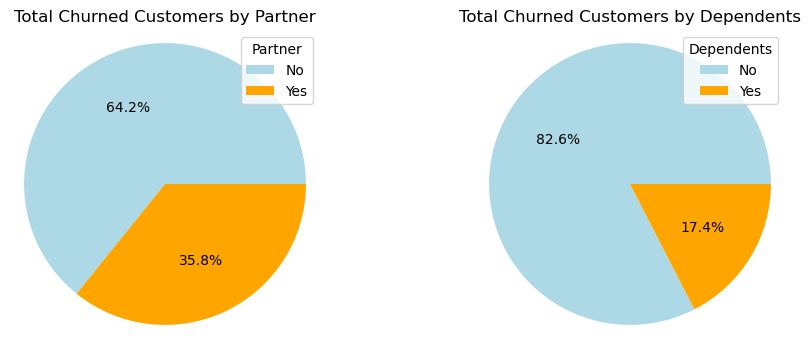

In [6]:
# Visualization for Churned customer partners & dependents
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
churned_by_partner = churned_customers['Partner'].value_counts()
plt.pie(churned_by_partner, labels=None, autopct='%1.1f%%', colors=['#ADD8E6', '#FFA500'])
plt.legend(churned_by_partner.index, title="Partner", loc="best")
plt.title('Total Churned Customers by Partner')
plt.axis('equal')

plt.subplot(1,2,2)
churned_by_dependents = churned_customers['Dependents'].value_counts()
plt.pie(churned_by_dependents, labels=None, autopct='%1.1f%%', colors=['#ADD8E6', '#FFA500'])
plt.legend(churned_by_dependents.index, title="Dependents", loc="best")
plt.title('Total Churned Customers by Dependents')
plt.axis('equal')

plt.subplots_adjust(wspace=0.5)
plt.show()

***Observation***: Customers no partner and no dependents are more likely to churn.

In [15]:
# Group the data by 'tenure_group' and count the number of churned customers in each group
bins = [0, 6, 12, 18, 24, churned_customers['tenure'].max()]
labels = ['0-6 Months', '6-12 Months', '12-18 Months', '18-24 Months', '>24 Months']
churned_customers.loc[:, 'tenure_group'] = pd.cut(churned_customers['tenure'], bins=bins, labels=labels)

grouped = churned_customers.groupby('tenure_group', observed=False).size().reset_index(name='total_churned_customers')

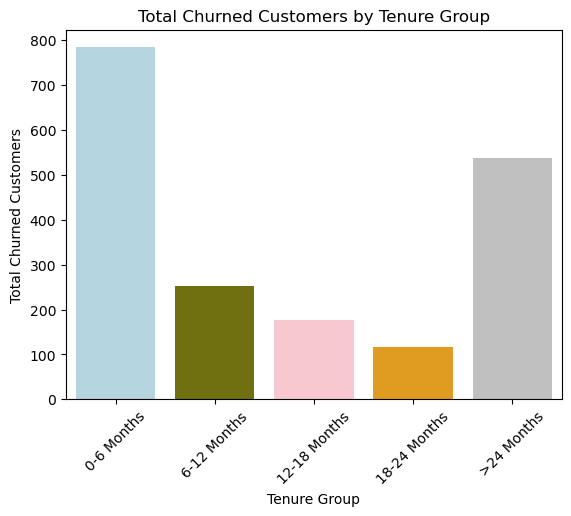

In [14]:
# Visualization for Churned customers' tenure group
sns.barplot(x='tenure_group', y='total_churned_customers', data=grouped, palette=['#ADD8E6', '#808000', '#FFC0CB', '#FFA500', '#C0C0C0'])
plt.title('Total Churned Customers by Tenure Group')
plt.xlabel('Tenure Group')
plt.ylabel('Total Churned Customers')
plt.xticks(rotation=45)
plt.show()

***Observation***: Customers tend to cancel their service and churn within the first 6 months.

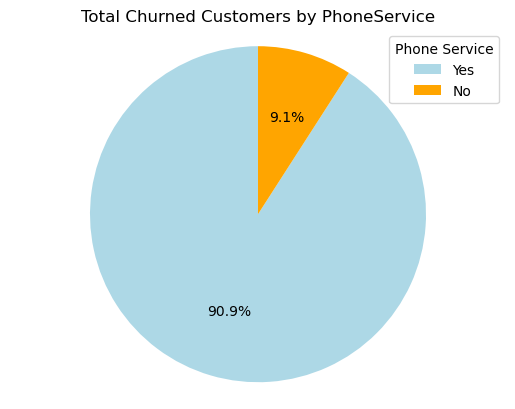

In [7]:
# Visualization for Churned customers' PhoneService
phoneService_count =  churned_customers['PhoneService'].value_counts()
plt.figure()
plt.pie(phoneService_count, labels=None, autopct='%1.1f%%', colors=['#ADD8E6', '#FFA500'], startangle=90)
plt.legend(phoneService_count.index, title="Phone Service", loc="best")
plt.title('Total Churned Customers by PhoneService')
plt.axis('equal')
plt.show()

***Observation***: Even with PhoneService provided, a large percentage of customers have still churned.

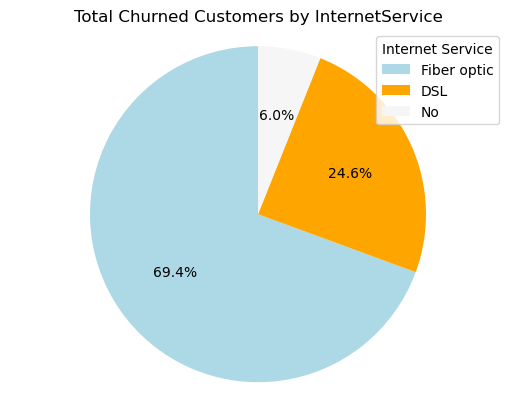

In [43]:
# Visualization for Churned customers' InternetService
InternetService_count =  churned_customers['InternetService'].value_counts()
plt.figure()
plt.pie(InternetService_count, labels=None, autopct='%1.1f%%', colors=['#ADD8E6', '#FFA500','#F6F6F6'], startangle=90)
plt.legend(InternetService_count.index, title="Internet Service", loc="best")
plt.title('Total Churned Customers by InternetService')
plt.axis('equal')
plt.show()

***Observation***: a large number of customers have shown resistance to using fiber optic cables for Internet service.

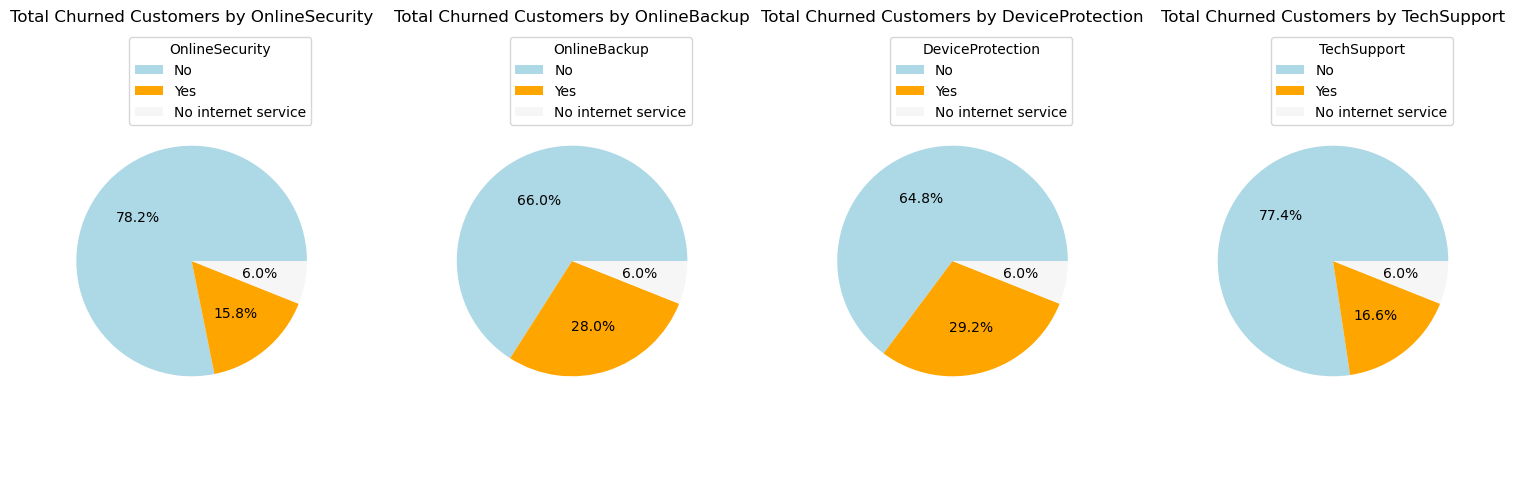

In [14]:
# Visualization of OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport services 
plt.figure(figsize=(18, 6))
plt.subplot(1,4,1)
churned_by_OnlineSecurity = churned_customers['OnlineSecurity'].value_counts()
plt.pie(churned_by_OnlineSecurity, labels=None, autopct='%1.1f%%', colors=['#ADD8E6', '#FFA500', '#F6F6F6'])
plt.legend(churned_by_OnlineSecurity.index, title="OnlineSecurity", loc="best")
plt.title('Total Churned Customers by OnlineSecurity')
plt.axis('equal')

plt.subplot(1,4,2)
churned_by_OnlineBackup = churned_customers['OnlineBackup'].value_counts()
plt.pie(churned_by_OnlineBackup, labels=None, autopct='%1.1f%%', colors=['#ADD8E6', '#FFA500', '#F6F6F6'])
plt.legend(churned_by_OnlineBackup.index, title="OnlineBackup", loc="best")
plt.title('Total Churned Customers by OnlineBackup')
plt.axis('equal')

plt.subplot(1,4,3)
churned_by_DeviceProtection = churned_customers['DeviceProtection'].value_counts()
plt.pie(churned_by_DeviceProtection, labels=None, autopct='%1.1f%%', colors=['#ADD8E6', '#FFA500', '#F6F6F6'])
plt.legend(churned_by_DeviceProtection.index, title="DeviceProtection", loc="best")
plt.title('Total Churned Customers by DeviceProtection')
plt.axis('equal')

plt.subplot(1,4,4)
churned_by_TechSupport = churned_customers['TechSupport'].value_counts()
plt.pie(churned_by_TechSupport, labels=None, autopct='%1.1f%%', colors=['#ADD8E6', '#FFA500', '#F6F6F6'])
plt.legend(churned_by_TechSupport.index, title="TechSupport", loc="best")
plt.title('Total Churned Customers by TechSupport')
plt.axis('equal')

plt.subplots_adjust(wspace=0.5)
plt.show()

***Observation***: The importance of providing OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport. An average of 71.6% of customers churned due to the lack of these services!

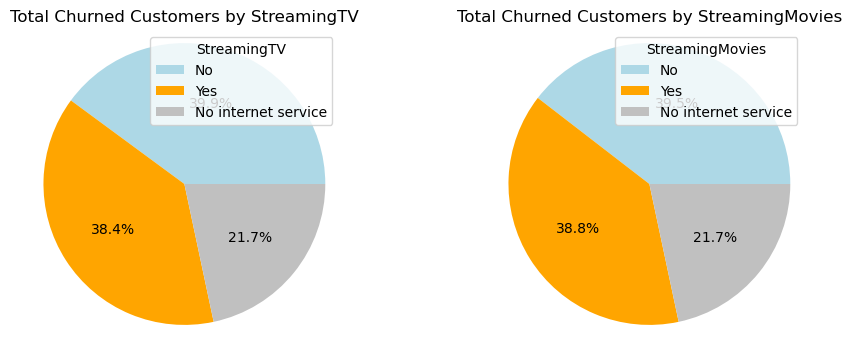

In [41]:
# Visualization of StreamingTV & StreamingMovies services 
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
StreamingTV = data['StreamingTV'].value_counts()
plt.pie(StreamingTV, labels=None, autopct='%1.1f%%', colors=['#ADD8E6', '#FFA500', '#C0C0C0'])
plt.legend(StreamingTV.index, title="StreamingTV", loc="best")
plt.title('Total Churned Customers by StreamingTV')
plt.axis('equal')

plt.subplot(1,2,2)
StreamingMovies = data['StreamingMovies'].value_counts()
plt.pie(StreamingMovies, labels=None, autopct='%1.1f%%', colors=['#ADD8E6', '#FFA500', '#C0C0C0'])
plt.legend(StreamingMovies.index, title="StreamingMovies", loc="best")
plt.title('Total Churned Customers by StreamingMovies')
plt.axis('equal')

plt.subplots_adjust(wspace=0.5)
plt.show()

***Observation***: Customers without StreamingTV and StreamingMovies services definitely churned.

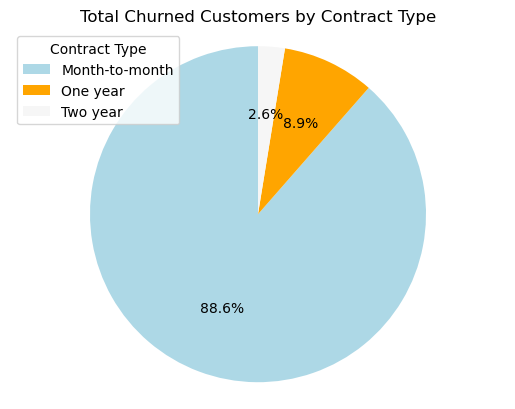

In [18]:
# Visualization for Churned customers' contract type
contract_count = churned_customers['Contract'].value_counts()
plt.figure()
plt.pie(contract_count, labels=None, autopct='%1.1f%%', colors=['#ADD8E6', '#FFA500','#F6F6F6'], startangle=90)
plt.legend(contract_count.index, title="Contract Type", loc="best")
plt.title('Total Churned Customers by Contract Type')
plt.axis('equal')
plt.show()

***Observation***: The churn rate for customers with a month-to-month contract is qiute high.

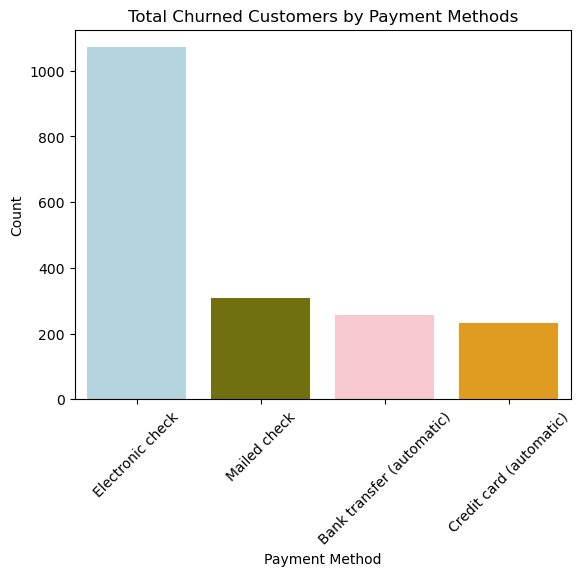

In [11]:
# Visualization for Churned customers' payment methods
payment_count = churned_customers['PaymentMethod'].value_counts()
ax = sns.barplot(x=payment_count.index,y=payment_count.values, palette=['#ADD8E6', '#808000', '#FFC0CB', '#FFA500'])
plt.title('Total Churned Customers by Payment Methods')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

***Observation***:  Customers clearly resented the use of the Electronic Check as a payment method.

[Text(0.5, 1.0, 'Total Churned Customers by MonthlyCharges')]

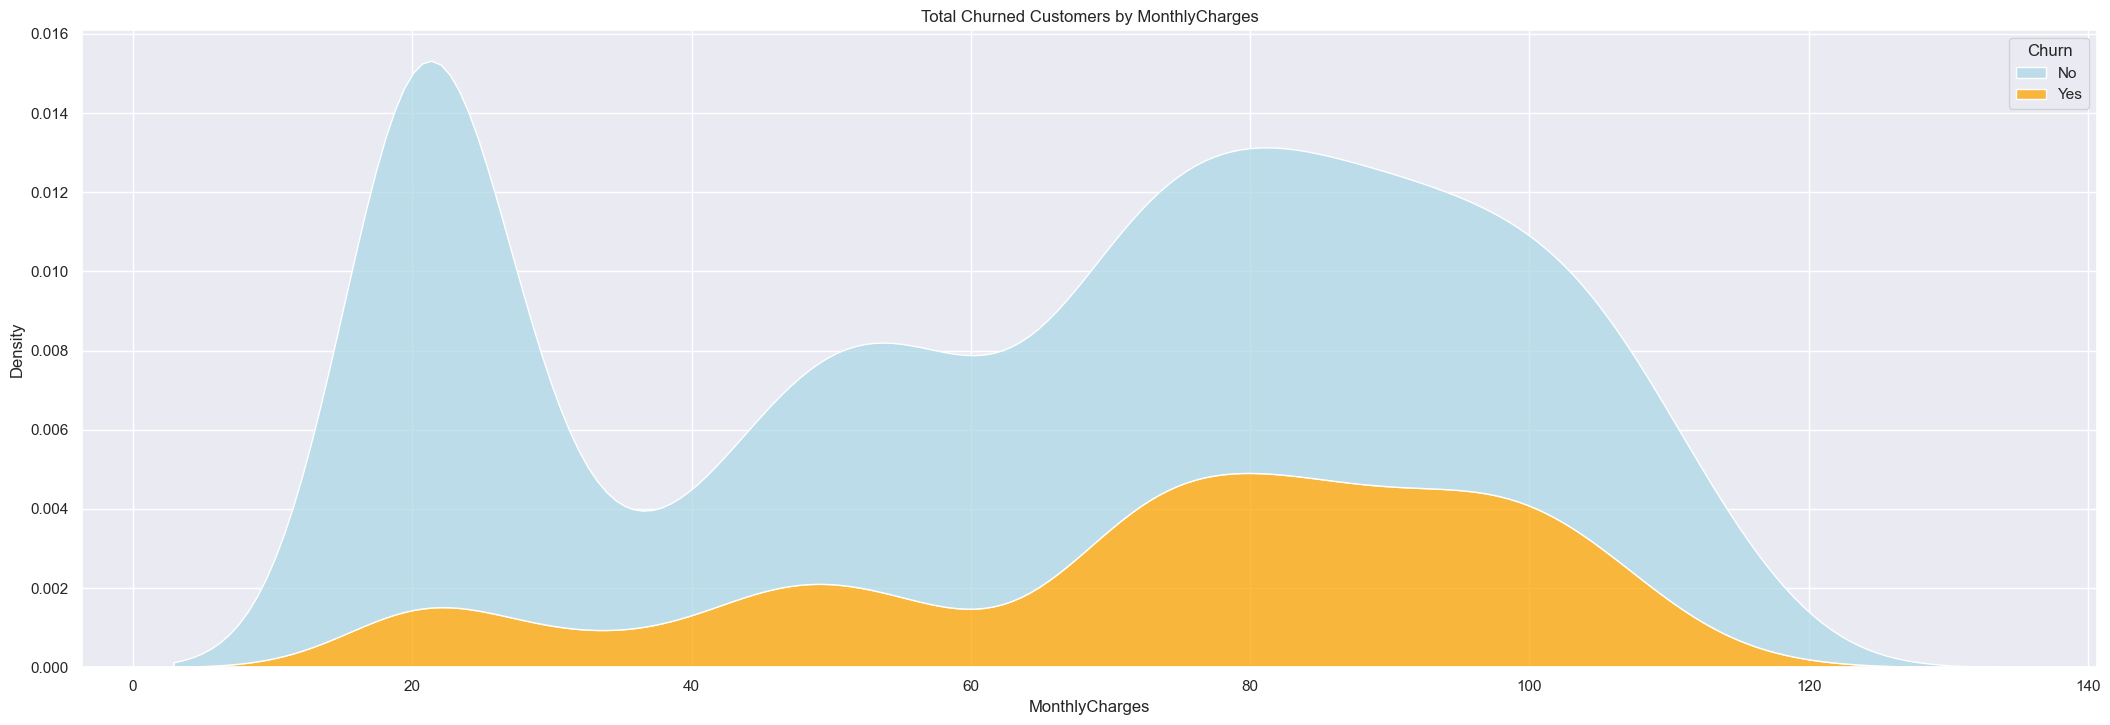

In [16]:
# Visualization of churn related to monthly charges
sns.set(rc={'figure.figsize':(26, 8.27)})
sns.kdeplot(data = data, x="MonthlyCharges", hue="Churn", multiple="stack",
            palette=['#ADD8E6', '#FFA500']).set(title="Total Churned Customers by MonthlyCharges")

***Observation***: As monthly charges increase, we observe a higher density (from 60 to 120), indicating that customer churn is rising with the increase in monthly charges.

In [18]:
# Convert TotalCharges to float, replacing ' ' with NaN
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# If there are still missing values after that, use mean imputation
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].mean())

[Text(0.5, 1.0, 'Total Churned Customers by TotalCharges')]

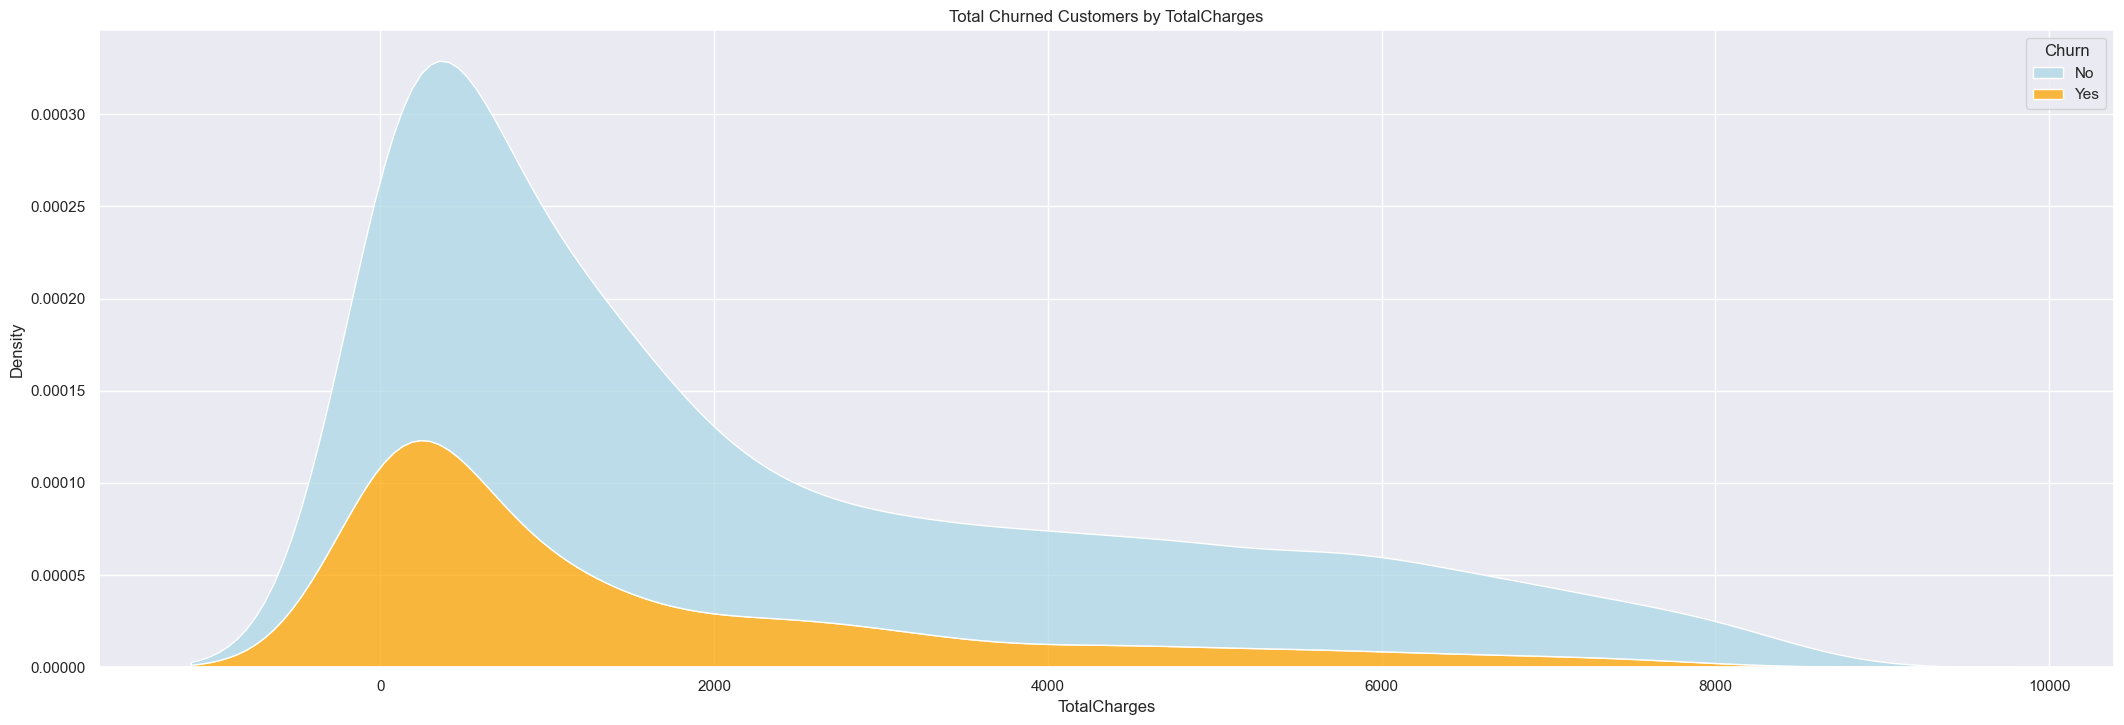

In [19]:
# Visualization of churn related to total charges
sns.set(rc={'figure.figsize':(26,8.27)})
sns.kdeplot(data=data, x="TotalCharges", hue="Churn", multiple="stack",
            palette=['#ADD8E6', '#FFA500']).set(title="Total Churned Customers by TotalCharges")

***Observation***: It is quite opposite of what has been seen for monthly charges. In this case, high churn occurs when total charges are lower. The highest churn is seen within the 0-2000 total charges range.

In [7]:
# Check data types and number of unique values in each column
dtypes = data.dtypes
nunique = data.nunique()
pd.DataFrame({'dtypes':dtypes,'nunique':nunique}).T

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
dtypes,object,object,int64,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,float64,object,object
nunique,7043,2,2,2,2,73,2,3,3,3,3,3,3,3,3,3,2,4,1585,6531,2


In [8]:
# Drop unnecessary columns
data.drop(['customerID'], axis=1, inplace=True)

In [10]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')

In [11]:
# Get Categorical Data
CatCols = data.select_dtypes(['object']).columns

In [10]:
# Convert categorical columns to numeric using LabelEncoder
label_encoder = {}
for column in CatCols :
    label = LabelEncoder()
    data[column] = label.fit_transform(data[column])
    label_encoder[column] = label

In [11]:
# Split dataset into features (X) and target (y)
X = data.drop('Churn', axis=1)
y = data['Churn']

In [12]:
# Apply SMOTEENN for both oversampling and cleaning for imbalanced data
smote_enn = SMOTEENN(random_state=42)
X_res, y_res = smote_enn.fit_resample(X, y)

df = pd.concat([X_res, y_res], axis=1)
print(pd.Series(y_res).value_counts())

Churn
1    3247
0    2661
Name: count, dtype: int64


In [13]:
# Scaling columns using standard scaler
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

**1- Supervised Learning Techniques:**

First, we apply supervised learning to predict whether a customer will churn or not based on the given features.

In [14]:
# Split data
X = df.drop('Churn', axis=1)
y = df['Churn']

In [15]:
# Convert a DataFrame X to a list of dictionaries for easly deployment
X_dict = X.to_dict(orient='records')

# Use DictVectorizerto to transform this list of dictionaries into a feature matrix
dv = DictVectorizer(sparse=False)
X = dv.fit_transform(X_dict)

In [16]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

Logistic Regression Model

In [17]:
# First: Using Logistic Regression Technique
lg = LogisticRegression(max_iter=1000).fit(X_train, y_train)

# Make predictions on the test set
y_pred = lg.predict(X_test)

In [18]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9247038917089678
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       561
           1       0.91      0.95      0.93       621

    accuracy                           0.92      1182
   macro avg       0.93      0.92      0.92      1182
weighted avg       0.93      0.92      0.92      1182



In [19]:
# Predict probabilities for the positive class
y_pred_proba = lg.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9809346663566613


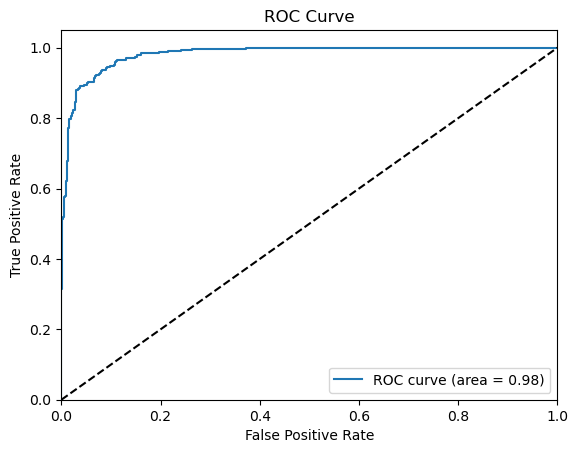

In [20]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Random Forest Classifier

In [21]:
# Second: Using Random Forest Classifier
random = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 150).fit(X_train, y_train)

# Make predictions on the test set
y_pred_rand = random.predict(X_test)

In [22]:
# Evaluate the model
accuracy =  accuracy_score(y_test, y_pred_rand)
print(f'Accuracy : {accuracy : }')

print(classification_report(y_test, y_pred_rand))

Accuracy :  0.9509306260575296
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       561
           1       0.94      0.97      0.95       621

    accuracy                           0.95      1182
   macro avg       0.95      0.95      0.95      1182
weighted avg       0.95      0.95      0.95      1182



In [23]:
# Predict probabilities for the positive class
y_pred_proba = random.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9898071364397025


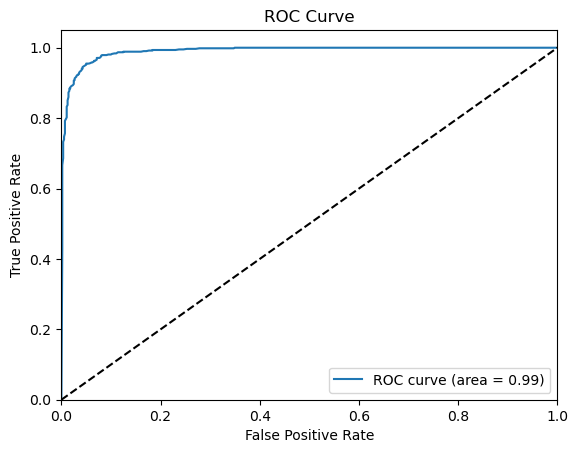

In [24]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

XGBoost Classifier

In [25]:
# Third: Using XGBoost 
xgb = XGBClassifier().fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb.predict(X_test)

In [26]:
# Evaluate the model
accuracy =  accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy : {accuracy : }')

print(classification_report(y_test, y_pred_xgb))

Accuracy :  0.9534686971235194
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       561
           1       0.94      0.97      0.96       621

    accuracy                           0.95      1182
   macro avg       0.95      0.95      0.95      1182
weighted avg       0.95      0.95      0.95      1182



In [27]:
# Predict probabilities for the positive class
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9910701215049043


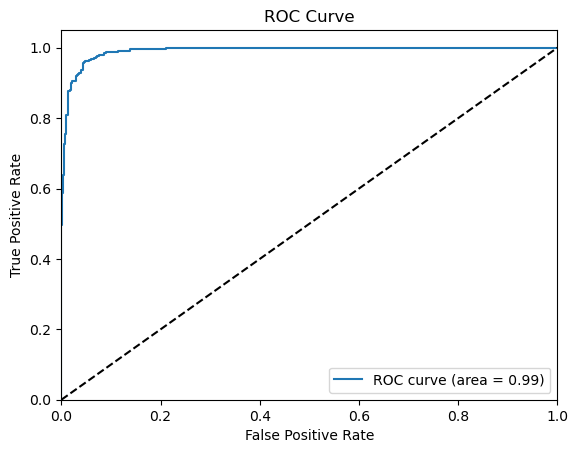

In [28]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

After we trying 3 different models, we can see that the best model is **XGBoost Classifier** with an accuracy of 95% and ROC AUC of 99%.


so we build our deployment pipline with this model.

In [29]:
# Save the model and DictVectorizer as .pkl file
with open('Customer Churn.pkl', 'wb') as f_out:
    pickle.dump((dv, xgb), f_out)

**2- Unsupervised Learning Techniques:**

Second, we use clustering to group similar customers together.

KMeans Clustering

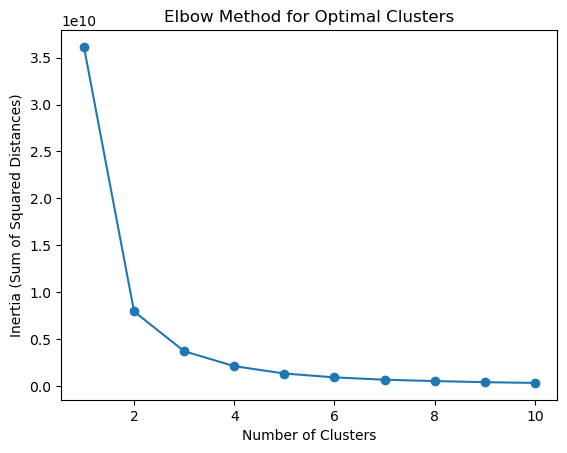

In [30]:
# Elbow Method for KMeans Clustering
inertia = []
range_clusters = range(1, 11)
for n_clusters in range_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure()
plt.plot(range_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.show()

In [33]:
# KMeans Clustering 
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data)
kmeans_labels = kmeans.labels_

# Calculate silhouette score for KMeans
silhouette_kmeans = silhouette_score(data, kmeans_labels)
print(f'Silhouette Score for KMeans: {silhouette_kmeans}')

Silhouette Score for KMeans: 0.6434613101047445


<function matplotlib.pyplot.colorbar(mappable: 'ScalarMappable | None' = None, cax: 'matplotlib.axes.Axes | None' = None, ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None, **kwargs) -> 'Colorbar'>

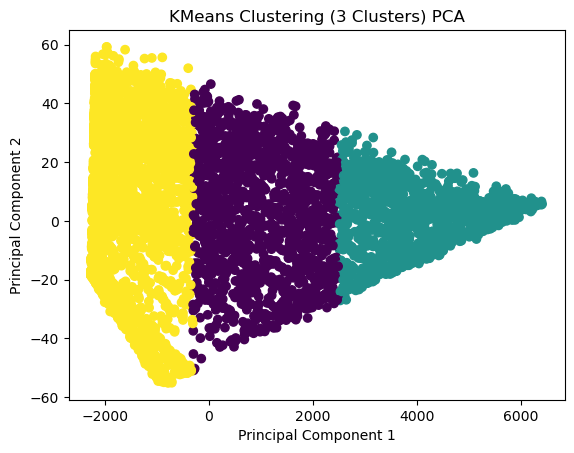

In [40]:
# PCA Visualization for KMeans Clustering
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

plt.figure()
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.title('KMeans Clustering (3 Clusters) PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar

DBSCAN Clustering

In [35]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan.fit(data)
dbscan_labels = dbscan.labels_

# Calculate Silhouette score, ignoring noise points (-1 label)
valid_clusters = dbscan_labels != -1
if valid_clusters.sum() > 1:  # Ensure there's more than 1 point in valid clusters
    silhouette_dbscan = silhouette_score(data[valid_clusters], dbscan_labels[valid_clusters])
else:
    silhouette_dbscan = -1  # Not enough clusters for a valid silhouette score

print(f'Silhouette Score for DBSCAN: {silhouette_dbscan}')

Silhouette Score for DBSCAN: 0.7401896680453963


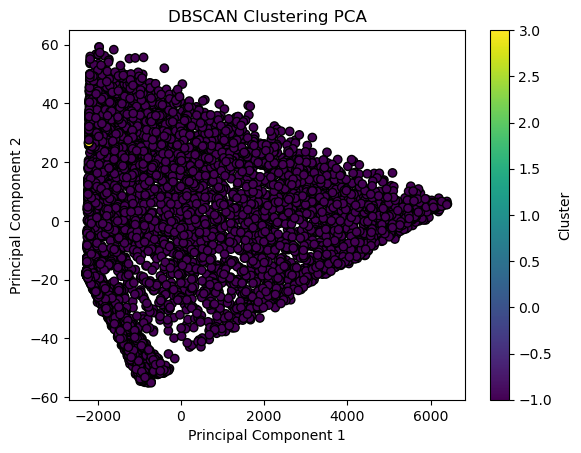

In [41]:
# PCA Visualization for DBSCAN 
plt.figure()
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=dbscan_labels, cmap='viridis', marker='o', edgecolor='k')
plt.title('DBSCAN Clustering PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

After trying two different clustering algorithms, **DBSCAN clustering algorithm** is the best fit for this dataset with Silhouette Score 0.74%